# ABM team - Technical interview

In [1]:
import random
import warnings

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
warnings.filterwarnings("ignore")

# Task 1
**[Data manipulation]** - Examine the data structure and import the dataset. Ensure that all data fields have the correct data type, and that no data has been lost during import step.

In [2]:
raw_data = pd.read_csv("postpaid_datamart.csv")

# Check column name & data type
data = raw_data.rename(columns={"Unnamed: 0": "CUSTOMER_ID"})

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16295 entries, 0 to 16294
Data columns (total 9 columns):
CUSTOMER_ID              16295 non-null int64
OG_INTL_FREE_CALL_MOU    1839 non-null float64
OG_ONN_FREE_CALL_MOU     5211 non-null float64
FREE_GPRS_MB             11477 non-null float64
TOTAL_REVENUE            11507 non-null float64
TOTAL_REVENUE_VAS        11507 non-null float64
ROAMING_REV              11477 non-null float64
F_CHURN_3M               16295 non-null int64
MONTH                    16295 non-null object
dtypes: float64(6), int64(2), object(1)
memory usage: 1.1+ MB


,CUSTOMER_ID,OG_INTL_FREE_CALL_MOU,OG_ONN_FREE_CALL_MOU,FREE_GPRS_MB,TOTAL_REVENUE,TOTAL_REVENUE_VAS,ROAMING_REV,F_CHURN_3M,MONTH
0,803985,NaN,NaN,29918.731,18.00,9.00,0.0,1,october
1,431536,NaN,NaN,0.013,9.76,4.88,0.0,1,october
2,59287,NaN,NaN,14688.529,36.00,18.00,0.0,1,october
3,19045,NaN,NaN,0.000,24.00,12.00,0.0,1,october
4,453323,1.15,1566.617,8537.953,68.62,34.31,0.0,1,october


# Task 2

**[Data manipulation]** - Carry out univariate exploratory data analysis on the dataset and answer the following questions:

1. Are missing values an issue in any of the variables? What method have you chosen for missing values imputation and why?
2. Are outliers an issue in any of the variables? What method have you chosen for outliers detection and why? 
    - Examine ‘FREE_GPRS_MB’ variable. Justify your decision with real life examples.
3. Examine and comment on the distribution of each variable (with graphs).


## Answer: 

1. Missing values would certainly casue issue based on the proportion. As we can see from above dataset summary, `OG_INTL_FREE_CALL_MOU` & `OG_ONN_FREE_CALL_MOU` columns contain too many NaN values to be used as functional features, the missing percentages are respectively 88% and 68%. For other columns, the missing percent is around 30%. Also some Machine Learning models aren't able to deal with missing values, thus imputation is needed. 

    For `OG_INTL_FREE_CALL_MOU` & `OG_ONN_FREE_CALL_MOU`, there's option that we can drop entire feature due to high missing ratio. However, they probably also have high importance for target `F_CHURN_3M	`, thus we can determine them by model comparision afterwards. If we keep all the features, then:
    - Drop rows with missing value, very simpel while a huge amount of data points will be dropped.
    - Fill with average/mode/median value, simple and reasonable for low ratio of missing values, not suitable for this case otherwise the original empirical distribution will be seriously polluted. 
    - **Fill with simulated empirical distribution random sampling value.** That is to get random samples by the empirical distribution of non-missing values. It not only keeps the information of non-missing values, but also adds random noises to dataset so that model based on it could be more robust. Please find the code work beneath.
    - More things TODO: This imputation method is not the only way. There are some other advanced and resonable ways worth to try when doing optimization, like Multivariate feature imputation, Nearest neighbors imputation, etc.
    ***
2. Outliers would be an issue when building GLM. An outlier is an observation that lies an abnormal distance from other values in a random sample from a population.Sometime it will lead to serious bias. Although the distribution for each variable seems unlikely to Normal Distribution, according to the **Central Limit Theorem**, we can use common z-score method to detect outliers. Also we can use some visualization tools like Box Plot or Scatter Plot to have more straight forward understanding about outliers. After outlier detection, we drop all outliers.
    
    PS: not sure about the `REVENUE` variables, whether they allow a negative value.If not, then just need to add an extra filter on it.
    ***
3. According to the distribution histogram for each variable, variables ['OG_INTL_FREE_CALL_MOU', 'OG_ONN_FREE_CALL_MOU', 'FREE_GPRS_MB'] are highly concentrated on 0. Let's check the target variable 'F_CHURN_3M', the counts of label 0 and label 1 is respectly 14035 and 1217, which is **imbalanced labeled**, thus the related variables are also imbalanced and consequently stack on 0. 

### Answer 1 Code

In [3]:
x_col = ['OG_INTL_FREE_CALL_MOU', 'OG_ONN_FREE_CALL_MOU', 'FREE_GPRS_MB', 'TOTAL_REVENUE', 'TOTAL_REVENUE_VAS', 'ROAMING_REV']
y_col = 'F_CHURN_3M'

# Mark missing value index
missing_index = {}
for col in x_col:
    missing_index[col] = data[col][data[col].isna()].index

In [4]:
# Empirical Distribution Sampling Imputation
# Use approximate descrete distribution to fit

def emp_sampling_imputation(population: pd.Series, bins: int = None):
    
    if population.isna().sum():
        valid_population = population.dropna().values
        if not bins:
            bins = len(valid_population) // 10
        bin_width = (valid_population.max() - valid_population.min()) / bins

        pmf, values = np.histogram(valid_population, bins=bins, density=True)
        cdf = np.cumsum(pmf) * bin_width

        samples = np.random.random((len(population) - len(valid_population), 1))
        samples = np.apply_along_axis(lambda x: values[np.abs(cdf - x).argmin()], 1, samples)

        # Two ways to generate noise
        # noises = np.random.normal(bin_width / 2, bin_width / 6, size=len(samples))
        noises = np.random.random(len(samples)) * bin_width

        population[population.isna()] = samples + noises

In [5]:
np.random.random(10) * 5

array([ 4.99063175,  1.26813348,  4.56009997,  2.87437259,  4.00389923,
        4.8774506 ,  3.11712299,  1.65097743,  4.34488242,  2.98001444])

In [6]:
# Start Imputatoin for each column

for col in x_col:
    emp_sampling_imputation(data[col])
    
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16295 entries, 0 to 16294
Data columns (total 9 columns):
CUSTOMER_ID              16295 non-null int64
OG_INTL_FREE_CALL_MOU    16295 non-null float64
OG_ONN_FREE_CALL_MOU     16295 non-null float64
FREE_GPRS_MB             16295 non-null float64
TOTAL_REVENUE            16295 non-null float64
TOTAL_REVENUE_VAS        16295 non-null float64
ROAMING_REV              16295 non-null float64
F_CHURN_3M               16295 non-null int64
MONTH                    16295 non-null object
dtypes: float64(6), int64(2), object(1)
memory usage: 1.1+ MB


,CUSTOMER_ID,OG_INTL_FREE_CALL_MOU,OG_ONN_FREE_CALL_MOU,FREE_GPRS_MB,TOTAL_REVENUE,TOTAL_REVENUE_VAS,ROAMING_REV,F_CHURN_3M,MONTH
0,803985,4.372167,35.302723,29918.731,18.00,9.00,0.0,1,october
1,431536,10.270787,21.924529,0.013,9.76,4.88,0.0,1,october
2,59287,23.816598,5.781870,14688.529,36.00,18.00,0.0,1,october
3,19045,19.102328,37.298835,0.000,24.00,12.00,0.0,1,october
4,453323,1.150000,1566.617000,8537.953,68.62,34.31,0.0,1,october


### Answer 2 Code

Current dataset size:  (15199, 9)


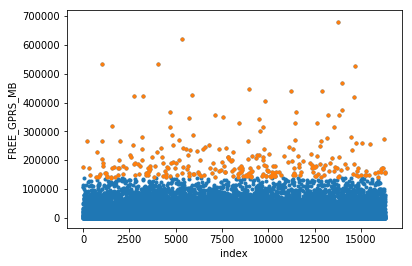

In [7]:
from scipy import stats

# Calculate Z-score
z_score = np.abs(stats.zscore(data[x_col]))
row_number, col_number = np.where(z_score > 3)

# Examine FREE_GPRS_MB variable
# x_col = ['OG_INTL_FREE_CALL_MOU', 'OG_ONN_FREE_CALL_MOU', 'FREE_GPRS_MB', 'TOTAL_REVENUE', 'TOTAL_REVENUE_VAS', 'ROAMING_REV']
# Get outliers for FREE_GPRS_MB variable
outliers_index = row_number[np.where(col_number == 2)[0]]

# Scatter Plot for FREE_GPRS_MB
plt.scatter(data.index, data["FREE_GPRS_MB"], marker=".")
plt.scatter(outliers_index, data["FREE_GPRS_MB"].loc[outliers_index], marker=".")
plt.xlabel("index")
plt.ylabel("FREE_GPRS_MB")

# Drop all outliers
data.drop(index=row_number, inplace=True)
print("Current dataset size: ", data.shape)

### Answer 3 Code

0    13975
1     1224
Name: F_CHURN_3M, dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000028F593B3C18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000028F59617E48>]], dtype=object)

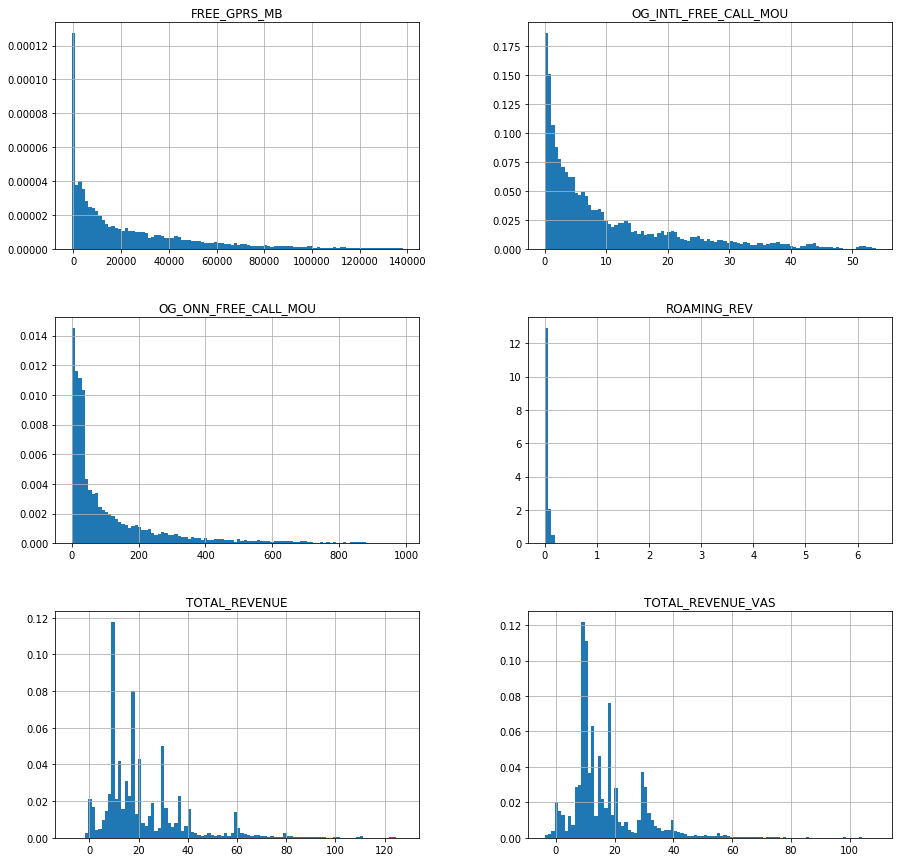

In [8]:
print(data["F_CHURN_3M"].value_counts())

data[x_col].hist(bins=100, density=True, figsize=(15, 15))

# Task 3	
**[Data manipulation]** - Carry out multivariate exploratory data analysis on the dataset and answer the following questions:

1.	Examine and comment on the seasonality trends (with graphs/charts).
2.	Plot pairwise relationship between input variables and calculate pairwise correlations. Do you think any variable needs to be excluded from the model and why?

## Answer:

1. In order to explore the seasonality trends, we need to gather `CUSTOMER_ID` with completed three months data. Here I write a customized function for seaonal visualization. According to the conditional bar plot for target variable "F_CHURN_3M", we can find there's a trend that churn number decreases as time goes by, which means the `MONTH` variable is also important variable related to target variable. For other variables trends, I give out both boxplot and histogram.

    Code work and plots can be found beneath.
    ***
2. Using Heat Map (aka Confusion Matrix) can easily describe pairwise relationship for each variables. Note that data need to be standardized before heat map. Because the dataset is imbalanced, thus the plot of before resampling performs worse than the one after resampling.
    
    After resampling, although the correlation with `F_CHURN_3M` numberically performance improves, it's still far from satisfactory, indicating that all predictor variables don't have very strong relationship with target variable. Here we set 0.01 as criterion of excluding variables from the model, since they are too weak to learn information.
    
    Note that resampling process is random, thus the correlation coefficient will be differnt by random seed.Here we just roughly determine variables `OG_INTL_FREE_CALL_MOU` & `TOTAL_REVENUE_VAS` excluded from baseline model.

### Answer 1 Code

In [9]:
# Add numerical month column into data
mon_to_num = {"october": 10, "november": 11, "december": 12}
data["month"] = data["MONTH"].apply(lambda x: mon_to_num[x])
x_col.append("month")

# Get list of customer id who has completed three months data 
customer_3 = data.groupby("CUSTOMER_ID")["month"].count()[data.groupby("CUSTOMER_ID")["month"].count() == 3].index.tolist()

data_3 = data[data["CUSTOMER_ID"].isin(customer_3)]

# Define generic seasonality ploting function
def seasonal_plot(df, col, is_target=False):
    
    if is_target:
        seasonal_array = df.groupby("month")[col]
        seasonal_df = seasonal_array.value_counts().to_frame("counts").reset_index()
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.bar(*seasonal_df[seasonal_df["F_CHURN_3M"] == 0][["month", "counts"]].values.T, width=0.5)
        ax1.set(xlabel="month", ylabel="counts", title="F_CHURN_3M = 0", xticks=[10, 11, 12], xticklabels=["Oct", "Nov", "Dec"])
        ax2.bar(*seasonal_df[seasonal_df["F_CHURN_3M"] == 1][["month", "counts"]].values.T, width=0.5)
        ax2.set(xlabel="month", ylabel="counts", title="F_CHURN_3M = 1", xticks=[10, 11, 12], xticklabels=["Oct", "Nov", "Dec"])
    else:
        df.boxplot(column=col, by="month", figsize=(10, 5))
        df.hist(column=col, by="month", bins=20, layout=(1,3), figsize=(15, 5))

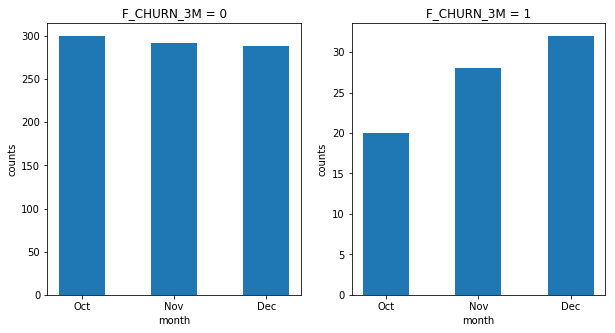

In [10]:
# Condictional Visualization

# Seasonal bar plot for target variable "F_CHURN_3M"
seasonal_plot(data_3, "F_CHURN_3M", is_target=True)

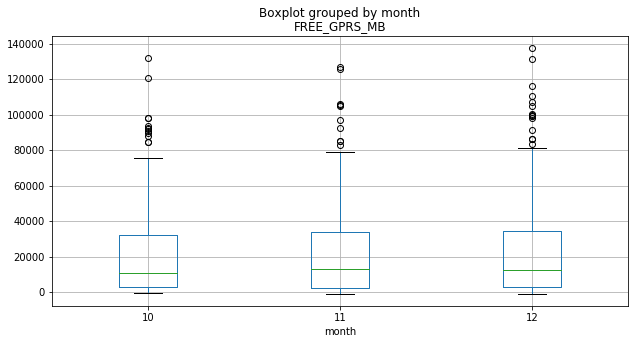

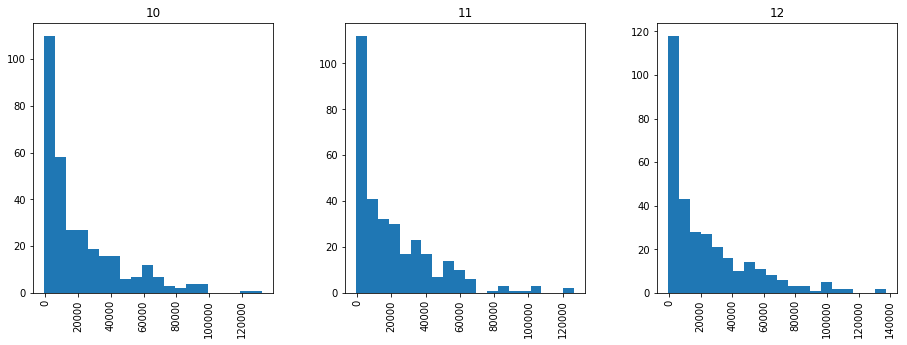

In [11]:
# Seasonal boxplot and histogram for variable "FREE_GPRS_MB"
seasonal_plot(data_3, "FREE_GPRS_MB", is_target=False)

# for col in x_col:
#     if col != "month":
#         seasonal_plot(data_3, col)

### Answer 2 Code

0    13975
1     1224
Name: F_CHURN_3M, dtype: int64

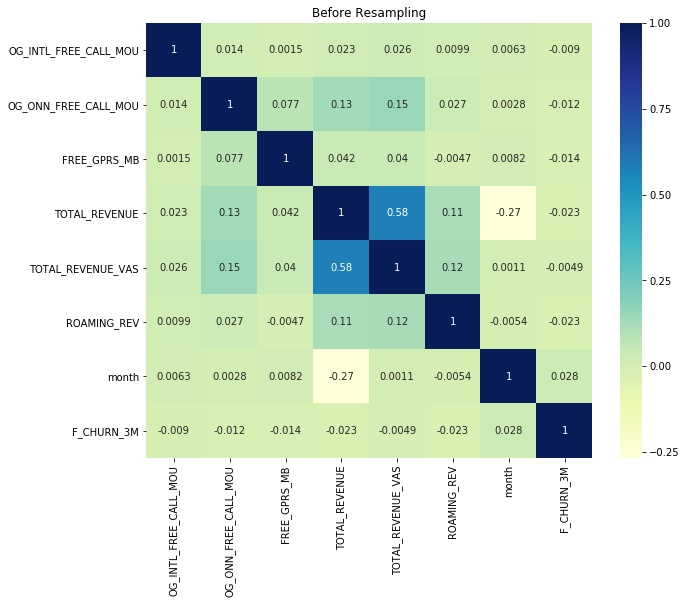

In [12]:
import seaborn as sns

data_norm = (data[x_col] - data[x_col].mean()) / data[x_col].std()
data_norm["F_CHURN_3M"] = data["F_CHURN_3M"]

# Before Resampling
_, ax = plt.subplots(figsize=(10, 8))
ax.set(title="Before Resampling")
sns.heatmap(data_norm.corr(), cmap='YlGnBu', ax=ax, annot=True)

# Show the number of 0 & 1 class
data_norm.F_CHURN_3M.value_counts()

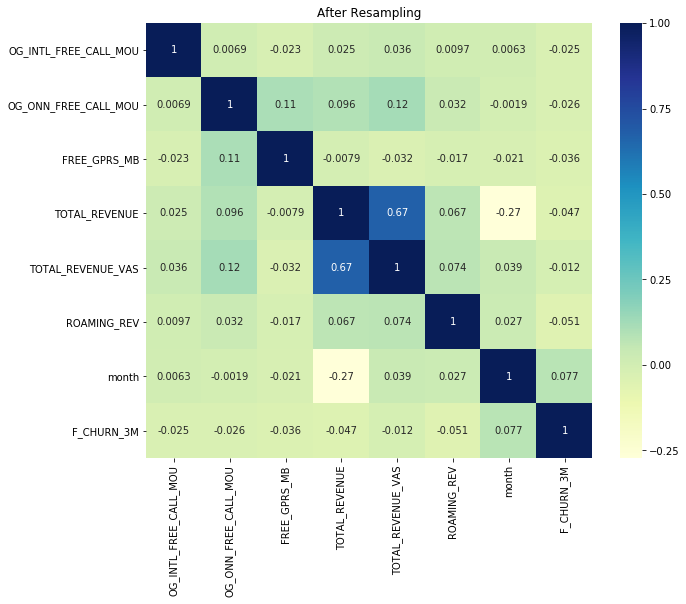

In [13]:
from sklearn.utils import resample


# Define customized downsampling function
def downsample(df, n_sample: int, seed: int = None):
    
    df_majority = df[df.F_CHURN_3M==0]
    df_minority = df[df.F_CHURN_3M==1]
    
    # Downsample majority class
    df_resample = resample(df_majority, replace=True, n_samples=n_sample,    
                           random_state=seed, # reproducible results
                          ) 
    
    # Combine minority class with downsampled majority class
    df_resampled = pd.concat([df_minority, df_resample])
    return df_resampled


# Resampling
data_resampled = downsample(data_norm, n_sample=1217, seed=0)

_, ax = plt.subplots(figsize=(10, 8))
ax.set(title="After Resampling")
sns.heatmap(data_resampled.corr(), cmap='YlGnBu', ax=ax, annot=True)


# Drop excluded variables
x_col.remove("OG_INTL_FREE_CALL_MOU")
x_col.remove("TOTAL_REVENUE_VAS")

# Task 4:
**[Statistical modelling]** - Create a churn prediction model (use logistic regression) and then answer the following questions:
1.	How would you evaluate your model’s performance? Define a quantitative measure
2.	What variables are important in the model and why?
3.	What are the steps you can take to improve the reliability and fit of the model? Which feature engineering techniques could you apply to try to improve existing model quality?


## Answer:

Please check code beneath for simple pipline of baseline model building.

1. The simplest metric is average accuracy score. For baseline model, the average score is around 0.54. Moreover, for binary classfication problem, we can look into some other metrics, like Precision, Recall, AUC, F1 score, etc. 

    ***

2. According to the Heat Map, variable `month`, `TOTAL_REVENUE`, `ROAMING_REV` have relative high correlation with target. And we can also design a experiment to exam. Remove different variable for each model, then compare the average score. The more important removed variable, the lower model average score. 

    Based on the experiment, `ROAMING_REV` is probably the most important variable.

    ***
    
3. There are so many aspects to improve the logistic regression model, here I list out some key points:

    - Other imbalanced dataset dealing method besides resampling, like change score function, modify signal weights, add fake data.
    - Hyper Parameters Tuning, there are lots of hyper-params in LogisticRegression, we can add a Cross-Validation process to tune them.
    - Data Cleaning, missing value imputation and drop outliers by other methods. 
    - Feature Engineering, try Log Transform, since variable distribution is highly concentrated, log can make it closer to normal distribution; try Time-Series data, the variable `MONTH` is a time-series data and have pretty high correlation with target; try OneHotCoding, instead of time-series data, variable `MONTH` can also be considered as categorical data.

### Baseline Model

In [14]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split

def build_baseline(df, x_col=x_col, resample_time=100):
    """
    Args:
        df (pd.DataFrame): DataFrame of X|y.
        x_col: The column names that included in estimator.
        resample_time (int): The number of resampling process.

    Returns:
        Tuple: ([estimator], [score])
    """
    estimators, scores = [], []
    estimator = LogisticRegression() # Just use default params

    for i in range(resample_time):

        data_resampled = downsample(df, n_sample=1217, seed=None)
        X = data_resampled[x_col].values
        y = data_resampled[y_col].T.values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        estimator.fit(X_train, y_train)
        estimators.append(estimator)
        scores.append(estimator.score(X_test, y_test))
    
    return estimators, scores

### Answer 1 Code

In [15]:
# Average accuracy score

_, scores = build_baseline(df=data_norm, x_col=x_col, resample_time=100)
print("Average accuracy score: ", np.mean(scores))

Average accuracy score:  0.523926380368


### Answer 2 Code

In [16]:
experiment = {}
for test in x_col:
    new_col = [x for x in x_col if x != test]
    _, scores = build_baseline(df=data_norm, x_col=new_col, resample_time=500)
    experiment[test] = np.mean(scores)
    print("Remove {}, the average score is {}.".format(test, experiment[test]))

Remove OG_ONN_FREE_CALL_MOU, the average score is 0.5252801635991821.
Remove FREE_GPRS_MB, the average score is 0.5274355828220858.
Remove TOTAL_REVENUE, the average score is 0.5290020449897751.
Remove ROAMING_REV, the average score is 0.5188466257668712.
Remove month, the average score is 0.5315787321063394.


# Task 5.	

**[Statistical modelling]** – Answer the following questions:

Identify other data sources, that might be used to improve the model quality.


## ANSWER:

According to previous work, we have a general understanding that current available data is pretty far from building a mature model. 

**Other Data Sources could help:**

- Full time-series data cover all months during multiple years, if possible can be devided by date.
- Customers information data, like region, birth date, job, sex, phone type, etc.
- More activity data, including text, IP, detailed plan revenue, phone call frequency & time, etc.